# CIFAR-10 Object Classification

The CIFAR-10 dataset contains 60k 32x32 pixel color images from 10 different classes.

The classes are:
- airplane 
- automobile 
- bird 
- cat 
- deer 
- dog 
- frog 
- horse 
- ship 
- truck

Tasks:

- implement the TODOs
- train a MLP to achieve >50% test accuracy
- train a CNN to achieve >80% test accuracy

Help:
- use the Keras API Documentation [https://www.keras.io/)

<hr>

# Download data

In [1]:
%%sh
# download CIFAR-10 if needed
if [ ! -d cifar-10-batches-py ]; then
    wget -c -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    tar xzf cifar-10-python.tar.gz
    rm cifar-10-python.tar.gz
fi

# Install keras

In [2]:
%%sh
pip install keras

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Imports

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# Preparations

In [2]:
# function to unpickle data files
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

# function to store  data in pickle file
def store(obj, filename):
    pickle.dump(obj, open('cifar-10-batches-py/' + filename, 'wb'))

In [3]:
# TODO: decode pickle data as images
# see https://www.cs.toronto.edu/~kriz/cifar.html for the storage format
def decode_as_image(img_flat):
    img_R = img_flat[0:1024]
    img_G = img_flat[1024:2048]
    img_B = img_flat[2048:3072]
    return np.dstack((img_R, img_G, img_B)).reshape(32, 32, 3)

# NOTE: alternatively use reshape & np.rollaxis

In [4]:
def showBGR(imgRGB):
    plt.figure(figsize=(12,8))
    plt.imshow(imgRGB)

In [5]:
# load train data and save to disk for later usage
# note: you might need to give Docker more memory
# alternatively, execute separately
x_train = []
for i in range(1, 6):
    x_train_b = unpickle('cifar-10-batches-py/data_batch_' + str(i)).get(bytes('data', 'ascii'))
    for img in x_train_b:
        img = decode_as_image(img)
        x_train.append(img)

x_train = np.array(x_train)
assert x_train.shape == (50000, 32, 32, 3)
#print(x_train[0].shape)
#showBGR(x_train[9])
        
# save to disk
store(x_train, 'x_train')

In [6]:
# load test data and save to disk for later usage
x_test = []
x_test_b = unpickle('cifar-10-batches-py/test_batch').get(bytes('data', 'ascii'))
for img in x_test_b:
    img = decode_as_image(img)
    x_test.append(img)

x_test = np.array(x_test)
assert x_test.shape == (10000, 32, 32, 3)
    
# save to disk
store(x_test, 'x_test')

In [7]:
# load train and test labels and save to disk
y_train = np.concatenate([
    unpickle('cifar-10-batches-py/data_batch_' + str(i)).get(bytes('labels', 'ascii'))
    for i in range(1, 6)
])
assert y_train.shape == (50000,)
store(y_train, 'y_train')

y_test = np.array(unpickle('cifar-10-batches-py/test_batch').get(bytes('labels', 'ascii')))
assert y_test.shape == (10000,)
store(y_test, 'y_test')

# Load prepared data

In [8]:
x_train = unpickle("cifar-10-batches-py/x_train")
x_test = unpickle("cifar-10-batches-py/x_test")
y_train = unpickle("cifar-10-batches-py/y_train")
y_test = unpickle("cifar-10-batches-py/y_test")

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


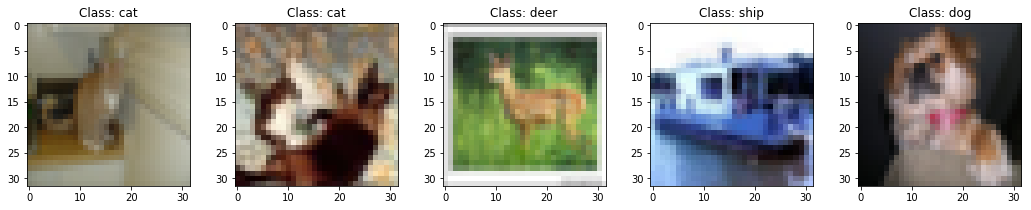

In [9]:
# show 5 random training samples
%matplotlib inline
import matplotlib.pyplot as plt

label_mapping = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(18,3))
for i, idx in enumerate(indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.title("Class: {}".format(label_mapping[int(y_train[idx])]))
    plt.imshow(x_train[idx])
plt.show()

# Prepare dataset for training and labels

In [10]:
# TODO: normalize data and cast to float32
# x_train = np.asarray([x / 255.0 for x in x_train])
# x_test = np.asarray([x / 255.0 for x in x_test])
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [11]:
x_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [12]:
# TODO: figure out number of classes (preferably from the data)
n_classes = len(unpickle('cifar-10-batches-py/batches.meta').get(bytes('label_names', 'ascii')))

In [13]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape

Using TensorFlow backend.


(50000, 10)

# The Multi Layer Perceptron

## 1. Define the model

In [14]:
# TODO: define the mlp model
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.models import Sequential

mlp = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(1024, activation='relu'),
    #Dropout(0.2),
    Dense(512, activation='relu'),
    #Dropout(0.2),
    Dense(256, activation='relu'),
    #Dropout(0.2),
    Dense(n_classes, activation='softmax')
])


mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 3,805,450
Trainable params: 3,805,450
Non-trainable params: 0
_________________________________________________________________


## 2. Compile the model

In [15]:
# TODO: fill in learning rate, change optimize, etc
from keras.optimizers import Adam, RMSprop

mlp.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.0001),
            metrics=['accuracy'])

## 3. Train (fit) the model

In [16]:
# TODO: decide training parameters, insert a learning rate schedule - GO WILD!
batch_size = 64
epochs = 10

mlp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
        validation_data=(x_test, y_test), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 41s 827us/step - loss: 1.8095 - accuracy: 0.3515 - val_loss: 1.6716 - val_accuracy: 0.4093
Epoch 2/10
50000/50000 [==============================] - 42s 850us/step - loss: 1.6168 - accuracy: 0.4256 - val_loss: 1.5724 - val_accuracy: 0.4379
Epoch 3/10
50000/50000 [==============================] - 44s 882us/step - loss: 1.5312 - accuracy: 0.4577 - val_loss: 1.5016 - val_accuracy: 0.4691
Epoch 4/10
50000/50000 [==============================] - 43s 859us/step - loss: 1.4698 - accuracy: 0.4783 - val_loss: 1.4447 - val_accuracy: 0.4825
Epoch 5/10
50000/50000 [==============================] - 40s 801us/step - loss: 1.4158 - accuracy: 0.4993 - val_loss: 1.4747 - val_accuracy: 0.4718
Epoch 6/10
50000/50000 [==============================] - 45s 894us/step - loss: 1.3713 - accuracy: 0.5158 - val_loss: 1.4593 - val_accuracy: 0.4821
Epoch 7/

## 4. Evaluate the model

Compute this metric:

$$\text{accuracy} = \frac{N_{\text{correct}}}{N_{\text{total}}}$$

Extra credit (for life, not this course): See [Wikipedia: Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for why accuracy is not always a good choice when evaluating models and what metric(s) to use instead.

In [17]:
# TODO: compute accuracy
def get_accuracy(predictions, ground_truth):
    return sum([(np.argmax(pred)==np.argmax(truth)) for pred, truth in zip(predictions, ground_truth)]) / len(predictions)

In [18]:
mlp_scores = mlp.evaluate(x_test, y_test, verbose=0)
predictions = mlp.predict(x_test)

print("MLP Accuracy:", mlp_scores[1])
print("My MLP Accuracy:", get_accuracy(predictions, y_test))
assert np.isclose(mlp_scores[1], get_accuracy(predictions, y_test))

MLP Accuracy: 0.5252000093460083
My MLP Accuracy: 0.5252


# The Convolutional Neural Network

In [ ]:
# TODO: define the cnn model
from keras.layers import MaxPooling2D, Flatten, Dense, Conv2D, Activation
from keras.models import Sequential

cnn = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(n_classes, activation='softmax')
])

cnn.summary()

## 2. Compile the model

In [ ]:
# TODO: fill in learning rate, change optimize, etc
from keras.optimizers import RMSprop

cnn.compile(loss='categorical_crossentropy',
            optimizer=RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

## 3. Train the model

Optional, but recommended: Add a [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to `cnn.fit()` to monitor the training.

In [ ]:
# TODO: decide training parameters, insert a learning rate schedule - GO WILD!
batch_size = 100
epochs = 4

cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
        validation_data=(x_test, y_test), shuffle=True)

## 4. Evaluate the model

In [ ]:
cnn_scores = cnn.evaluate(x_test, y_test, verbose=0)
predictions = cnn.predict(x_test)

print("CNN Accuracy:", cnn_scores[1])
print("My CNN Accuracy:", get_accuracy(predictions, y_test))
assert np.isclose(cnn_scores[1], get_accuracy(predictions, y_test))